<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/dataset'

    # Install required packages
    !pip install torch_geometric
    import torch
    from torch_geometric.data import Data, DataLoader

else:
    dataset_path = 'dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

## The data

In [3]:
# Load the data
# Training set
train_graphs = torch.load(f"{dataset_path}/combined/training.pt", weights_only=False)

# Validating set
val_graphs = torch.load(f"{dataset_path}/combined/validating.pt", weights_only=False)

# Testing set
test_graphs = torch.load(f"{dataset_path}/combined/testing.pt", weights_only=False)

In [4]:
# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

## Build model

### import dependancies

In [5]:
# import dependancies
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv

In [6]:
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate model, optimizer, loss
# run the model in the gpu if the device has one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instance of the model
model = GNNModel(node_dim=8, edge_dim=3, hidden_dim=32).to(device) # Without global features
# model = GNNModel(node_dim=8, edge_dim=3, global_dim=10, hidden_dim=32).to(device) # with global features


# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
loss_fn = nn.MSELoss()

In [7]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = loss_fn(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = loss_fn(out.view(-1), data.y.view(-1))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Train model
train_losses = []
val_losses = []
for epoch in range(1, 41):
    train_loss = train()
    val_loss = evaluate(val_loader)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Test model
test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 001, Train Loss: 2.9267, Val Loss: 0.0403
Epoch 002, Train Loss: 0.0349, Val Loss: 0.0275
Epoch 003, Train Loss: 0.0299, Val Loss: 0.0235
Epoch 004, Train Loss: 0.0254, Val Loss: 0.0225
Epoch 005, Train Loss: 0.0258, Val Loss: 0.0261
Epoch 006, Train Loss: 0.0227, Val Loss: 0.0196
Epoch 007, Train Loss: 0.0224, Val Loss: 0.0190
Epoch 008, Train Loss: 0.0216, Val Loss: 0.0170
Epoch 009, Train Loss: 0.0196, Val Loss: 0.0271
Epoch 010, Train Loss: 0.0198, Val Loss: 0.0204
Epoch 011, Train Loss: 0.0180, Val Loss: 0.0146
Epoch 012, Train Loss: 0.0199, Val Loss: 0.0160
Epoch 013, Train Loss: 0.0185, Val Loss: 0.0165
Epoch 014, Train Loss: 0.0181, Val Loss: 0.0164
Epoch 015, Train Loss: 0.0189, Val Loss: 0.0150
Epoch 016, Train Loss: 0.0181, Val Loss: 0.0154
Epoch 017, Train Loss: 0.0191, Val Loss: 0.0171
Epoch 018, Train Loss: 0.0190, Val Loss: 0.0168
Epoch 019, Train Loss: 0.0176, Val Loss: 0.0186
Epoch 020, Train Loss: 0.0175, Val Loss: 0.0153
Epoch 021, Train Loss: 0.0201, Val Loss:

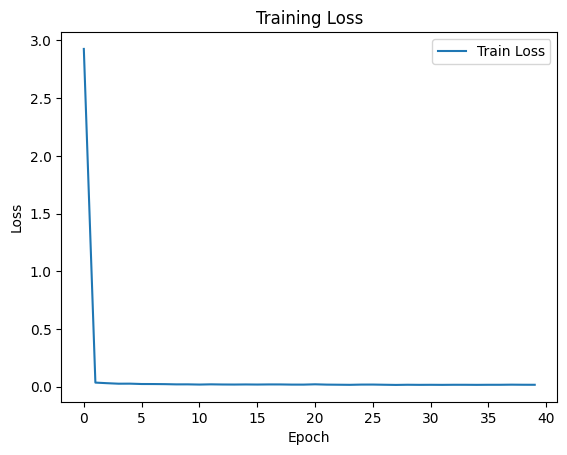

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [9]:
predicted_values = []
actual_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        predicted = model(data.x, data.edge_index, data.edge_attr, data.batch)

        predicted_values.append(predicted.numpy())
        actual_values.append(data.y.numpy())

In [10]:
total = len(predicted_values)
all_predicted_values = predicted_values[0].flatten()
i = 1
while i != total:
    new_predicted_values = predicted_values[i].flatten()

    all_predicted_values = np.concatenate((all_predicted_values, new_predicted_values), axis=0)
    i += 1

print(all_predicted_values)

[1.6666429  0.2656389  0.24548993 ... 1.2796326  0.3800435  0.25652227]


In [11]:
total = len(actual_values)
all_actual_values = actual_values[0].flatten()
i = 1
while i != total:
    new_actual_values = actual_values[i].flatten()

    all_actual_values = np.concatenate((all_actual_values, new_predicted_values), axis=0)
    i += 1

print(all_actual_values)

[1.8146     0.2059     0.1923     ... 1.2796326  0.3800435  0.25652227]


In [12]:
for i in range(10):
    print(f"Predicted: {all_predicted_values[i]}, Actual: {all_actual_values[i]}")

Predicted: 1.6666429042816162, Actual: 1.8145999908447266
Predicted: 0.26563888788223267, Actual: 0.20589999854564667
Predicted: 0.2454899251461029, Actual: 0.1923000067472458
Predicted: 0.9743042588233948, Actual: 1.1014000177383423
Predicted: 0.24754071235656738, Actual: 0.2071000039577484
Predicted: 0.2724834680557251, Actual: 0.34150001406669617
Predicted: 0.4891395568847656, Actual: 0.3810499906539917
Predicted: 1.1998403072357178, Actual: 1.2666000127792358
Predicted: 0.4110981822013855, Actual: 0.42384999990463257
Predicted: 1.7655531167984009, Actual: 1.808899998664856


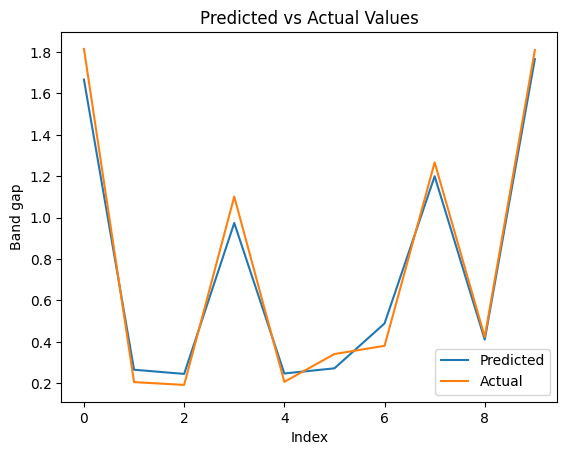

In [13]:
# Produce a graph
plt.plot(all_predicted_values[:10], label='Predicted')
plt.plot(all_actual_values[:10], label='Actual')
plt.xlabel('Index')
plt.ylabel('Band gap')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()